In [1]:
import pandas as pd
import numpy as np

import datetime as dt
from pandas.tseries.offsets import MonthEnd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

plt.rcParams["figure.figsize"] = [10, 6]
# Set up with a higher resolution screen 
%config InlineBackend.figure_format = 'retina'

#### Load annotation files

In [2]:
causal = pd.read_excel('Annotations_XAI_Biomedical.xlsx', sheet_name= 'Causal')
exp = pd.read_excel('Annotations_XAI_Biomedical.xlsx', sheet_name= 'Explainability')

causal['date'] = pd.to_datetime(causal['date'])
exp['date'] = pd.to_datetime(exp['date'])

/Users/vesna/opt/anaconda3/envs/xai/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '19/04/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)


#### Create  dataframe concatenating causal and exp

In [3]:
category = causal['paper category'].tolist() + exp['paper category'].tolist()
dates = causal['date'].tolist() + exp['date'].tolist()
covid = causal['role of covid'].tolist() + exp['role of COVID'].tolist()
titles = causal['title'].tolist() + exp['title'].tolist()


df = pd.DataFrame(data = {'Relation to XAI': category, 'Role of Covid-19': covid,
                          'Date of publication': dates, 'Title': titles})

df['Covid-related'] = np.where(df['Role of Covid-19']=='Covid is not mentioned in the title or abstract', 'No', 'Yes')

df.head()

,Relation to XAI,Role of Covid-19,Date of publication,Title,Covid-related
0,evaluation or application of XAI methods,Covid is not mentioned in the title or abstract,2022-11-01,A study to create a risk factor models to pred...,No
1,discussion of concepts of XAI,Covid is not mentioned in the title or abstract,2022-10-29,Machine Learning for Causal Inference in Biolo...,No
2,evaluation or application of XAI methods,Covid is not mentioned in the title or abstract,2022-10-25,Single-cell multiome of the human retina and d...,No
3,introduction of novel methods of XAI,Covid is not mentioned in the title or abstract,2022-10-23,DeepPerVar: a multimodal deep learning framewo...,No
4,discussion of concepts of XAI,Covid is not mentioned in the title or abstract,2022-10-20,Mapping of machine learning approaches for des...,No


#### remove papers with errors

In [4]:
df = df[(df['Relation to XAI'] != 'not in English') & (df['Relation to XAI'] != 'other error') & \
       (df['Relation to XAI'] != 'unsure') & (df['Title'] != 'duplicated')]

In [5]:
print('Final number of papers for the analysis: %d' %df.shape[0])

Final number of papers for the analysis: 1278


In [6]:
df['Relation to XAI'].value_counts()

evaluation or application of XAI methods      642
introduction of novel methods of XAI          214
discussion of concepts of XAI                 170
review paper                                  126
dataset and tools that support XAI methods    123
Name: Relation to XAI, dtype: int64

In [7]:
df['Role of Covid-19'].value_counts()

Covid is not mentioned in the title or abstract                    1137
Covid data/use case is the topic of the study                       101
Covid is mentioned as a reason/driving force for explainability      37
Name: Role of Covid-19, dtype: int64

### Trends

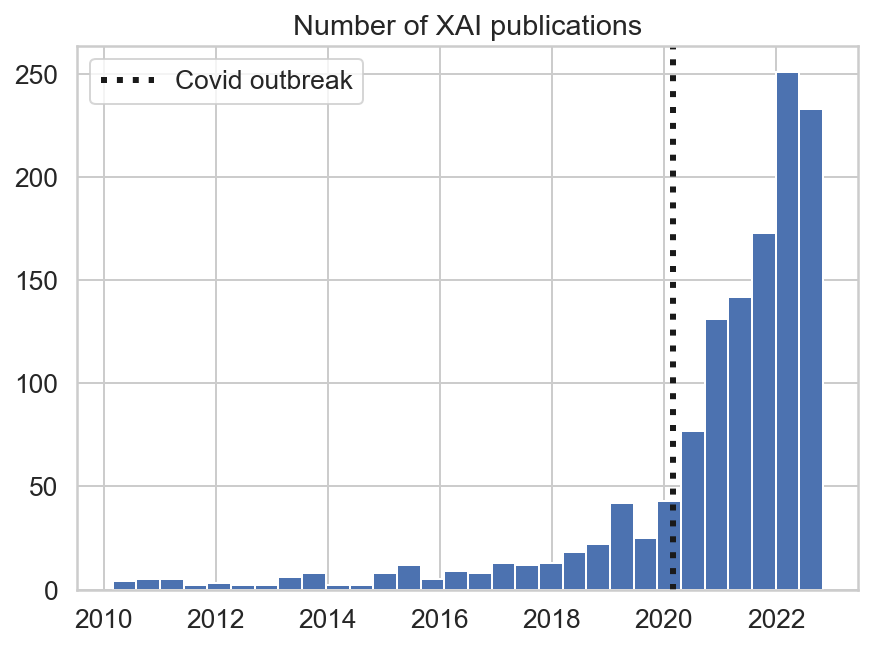

In [8]:
plt.figure(figsize=(7,5))            
plt.hist(df['Date of publication'], bins = 30)
plt.title('Number of XAI publications')
plt.axvline(dt.datetime(2020, 3, 1), label = 'Covid outbreak', lw = 3, c = 'k', ls = 'dotted')
plt.legend()
plt.show()

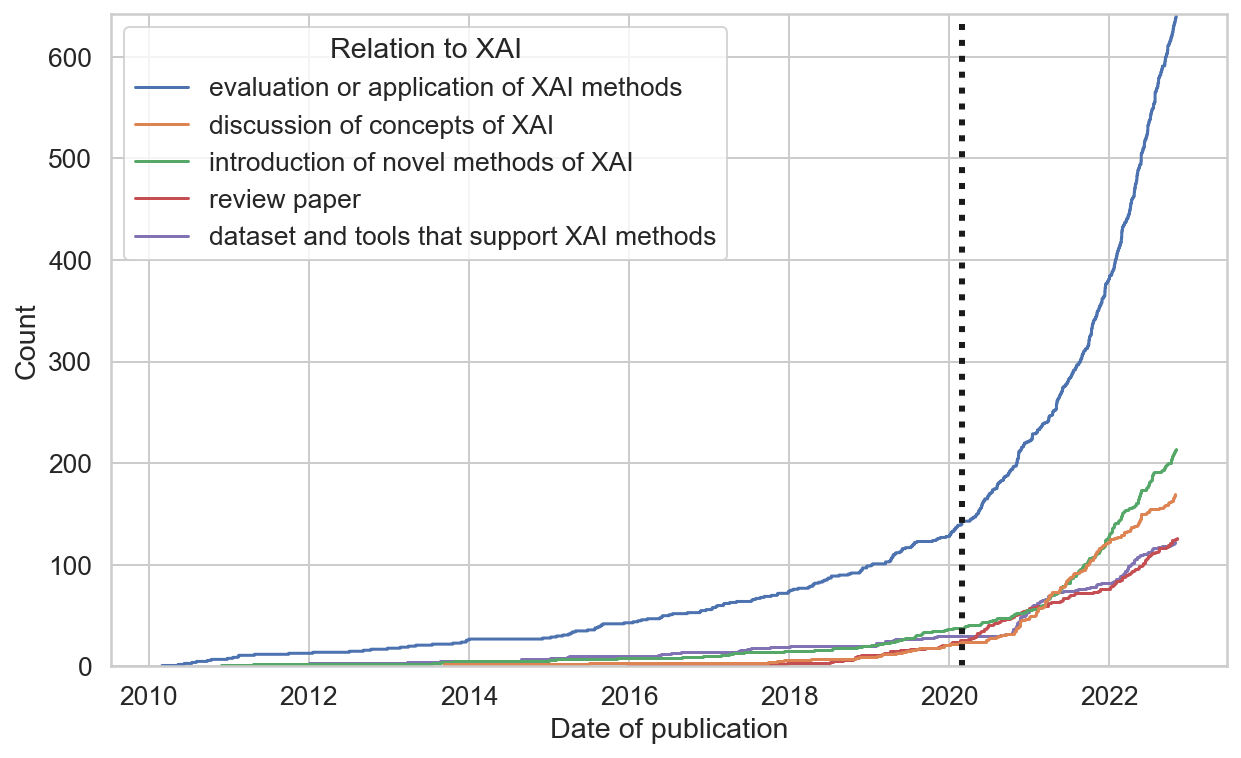

In [9]:
sns.ecdfplot(data=df, x="Date of publication", hue="Relation to XAI", stat="count")
plt.axvline(dt.datetime(2020, 3, 1), label = 'Covid outbreak', lw = 3, c = 'k', ls = 'dotted')
plt.show()

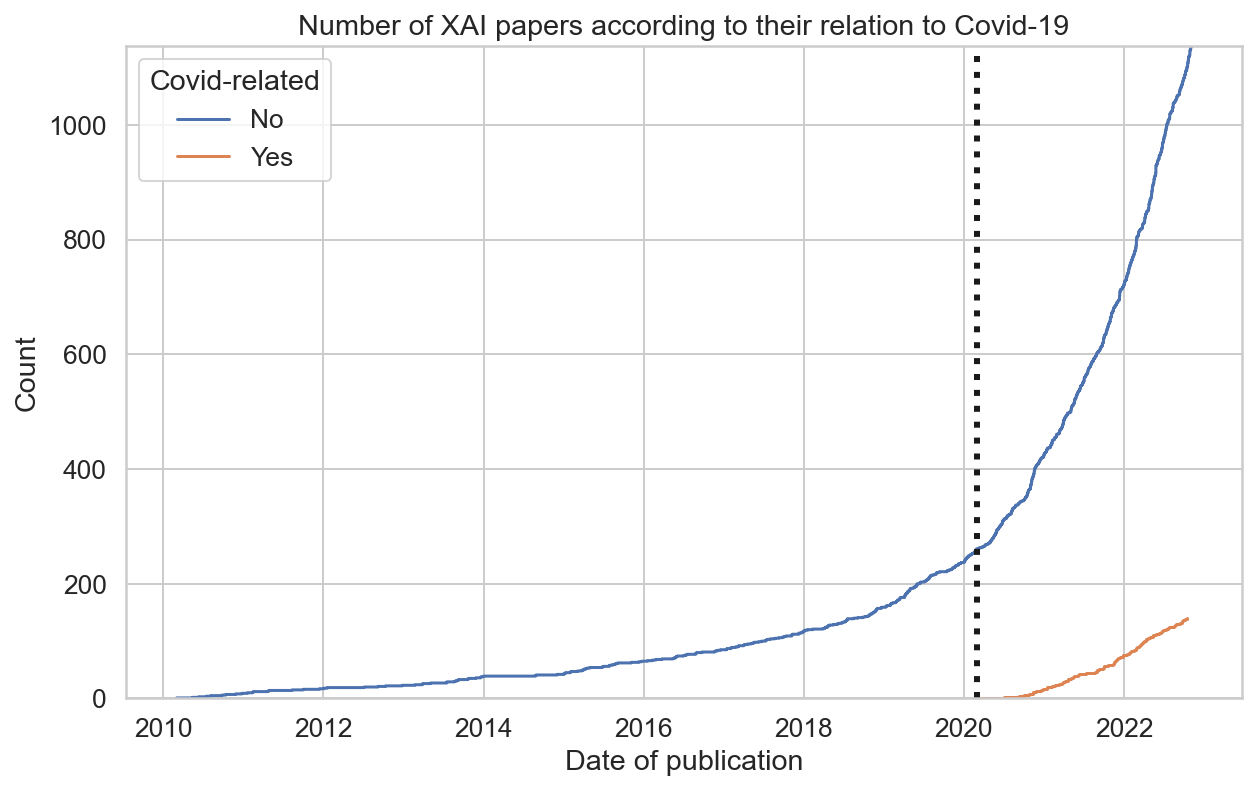

In [10]:
sns.ecdfplot(data=df, x="Date of publication", hue="Covid-related", stat="count")
plt.axvline(dt.datetime(2020, 3, 1), label = 'Covid outbreak', lw = 3, c = 'k', ls = 'dotted')
plt.title('Number of XAI papers according to their relation to Covid-19')
plt.show()

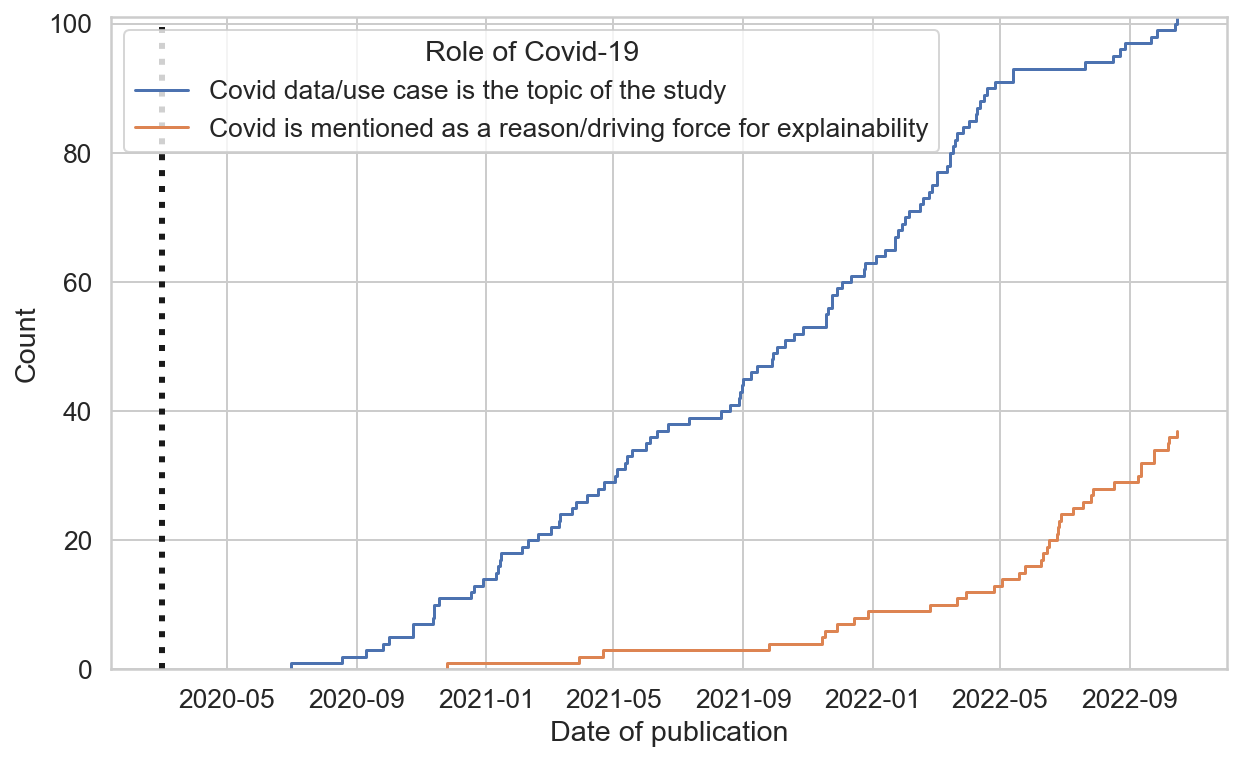

In [11]:
df2 = df[df['Role of Covid-19'] != 'Covid is not mentioned in the title or abstract']
sns.ecdfplot(data=df2, x="Date of publication", hue="Role of Covid-19", stat="count")
plt.axvline(dt.datetime(2020, 3, 1), label = 'Covid outbreak', lw = 3, c = 'k', ls = 'dotted')
plt.show()

#### Get number of publications in PubMed Biomedical AI per quarter year

In [12]:
biomed_ai = pd.read_csv('biomed_ai_count.csv')

# transform date into last day of the month
biomed_ai['Date'] = pd.to_datetime(biomed_ai['Date'], format="%Y/%m") + MonthEnd(0)

# transform data into quarter periods
biomed_ai = pd.DataFrame(biomed_ai.groupby(biomed_ai['Date'].dt.to_period('Q'))['Count'].sum())
biomed_ai = pd.DataFrame(biomed_ai)
biomed_ai.columns = ['Number of publications']
biomed_ai.head()

,Number of publications
Date,
2010Q1,749
2010Q2,709
2010Q3,890
2010Q4,963
2011Q1,899


#### Get number of PubMed Biomedical XAI per quarter year

In [13]:
xai = df.groupby(df['Date of publication'].dt.to_period('Q'))['Title'].count()
xai = pd.DataFrame(xai)
xai.columns = ['Number of publications']
xai.head()

,Number of publications
Date of publication,
2010Q1,1
2010Q2,2
2010Q3,3
2010Q4,3
2011Q1,3


In [14]:
start_date, end_date = pd.Timestamp(2010, 1, 1), pd.Timestamp(2022, 12, 30)

quarters = (pd.date_range(pd.to_datetime(start_date), 
                   pd.to_datetime(end_date) + pd.offsets.QuarterBegin(1), freq='Q').tolist())

df_quarter = pd.DataFrame(data = {
                        "Date": quarters,
                        "Count_Biomed_AI":biomed_ai["Number of publications"].rolling(4).mean(),
                        "Count_Biomed_XAI":xai["Number of publications"].rolling(4).mean()
                        })

df_quarter["Ratio"] = df_quarter["Count_Biomed_XAI"]/df_quarter["Count_Biomed_AI"]

# some quarters have nan values because there weren't XAI papers published in this period, so we fill them with 0
df_quarter = df_quarter.fillna(0)
df_quarter.head()

,Date,Count_Biomed_AI,Count_Biomed_XAI,Ratio
2010Q1,2010-03-31,0.00,0.00,0.000000
2010Q2,2010-06-30,0.00,0.00,0.000000
2010Q3,2010-09-30,0.00,0.00,0.000000
2010Q4,2010-12-31,827.75,2.25,0.002718
2011Q1,2011-03-31,865.25,2.75,0.003178


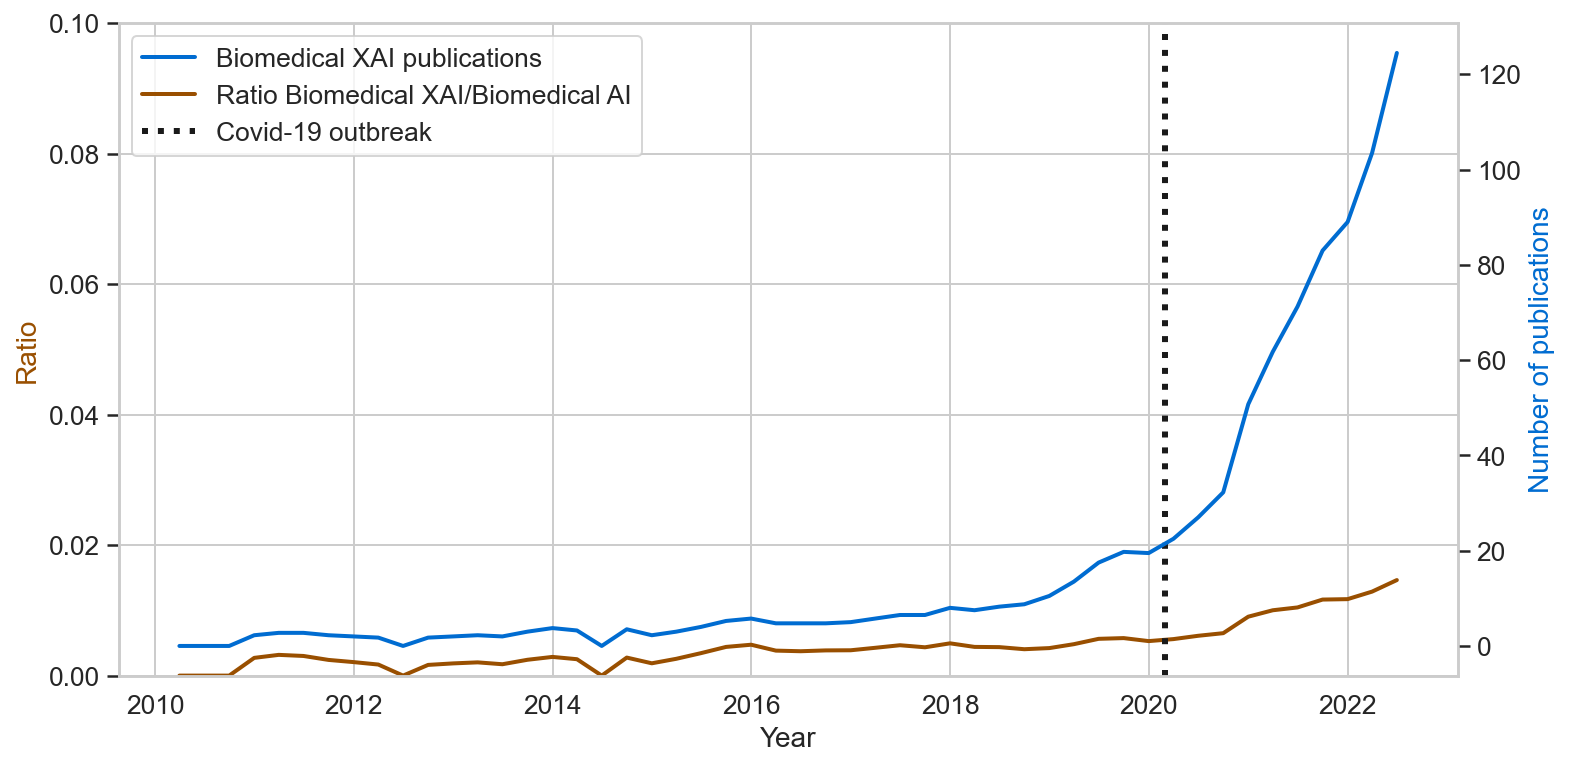

In [15]:
fig, ax1 = plt.subplots(figsize = (12, 6))

ax2 = ax1.twinx()

ax1.plot(df_quarter['Date'].iloc[:-2], df_quarter["Ratio"].iloc[:-2], 
         label = 'Ratio Biomedical XAI/Biomedical AI', color = '#994F00', lw=2)

ax1.axvline( pd.Timestamp(2020, 3, 1), label = 'Covid-19 outbreak', lw = 3, c = 'k', ls = 'dotted')

ax2.plot(df_quarter['Date'].iloc[:-2], df_quarter['Count_Biomed_XAI'].iloc[:-2],
         label = 'Biomedical XAI publications', color = '#006CD1', lw=2)

lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)


ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Ratio', color='#994F00', fontsize=14)
ax1.set_ylim(0, 0.1)
ax2.set_ylabel('Number of publications', color = '#006CD1', fontsize=14)
plt.grid()

plt.show()


In [16]:
df_quarter_xai_categories = df.groupby(['Relation to XAI', 
                                        df['Date of publication'].dt.to_period('Q')])['Relation to XAI'].count().unstack()
df_quarter_xai_categories = df_quarter_xai_categories.fillna(0)
df_quarter_xai_categories = df_quarter_xai_categories.T
df_quarter_xai_categories = df_quarter_xai_categories.reset_index(drop=False)

df_quarter_xai_categories[['dataset and tools that support XAI methods',
                          'discussion of concepts of XAI',
                          'evaluation or application of XAI methods',
                          'introduction of novel methods of XAI',
                          'review paper']] = df_quarter_xai_categories[['dataset and tools that support XAI methods',
                          'discussion of concepts of XAI',
                          'evaluation or application of XAI methods',
                          'introduction of novel methods of XAI',
                          'review paper']].rolling(4).mean()
# transform from quarter to date
df_quarter_xai_categories ['Date'] = pd.PeriodIndex(df_quarter_xai_categories['Date of publication'],
                                                    freq='Q').to_timestamp()
df_quarter_xai_categories.head()

Relation to XAI,Date of publication,dataset and tools that support XAI methods,discussion of concepts of XAI,evaluation or application of XAI methods,introduction of novel methods of XAI,review paper,Date
0,2010Q1,NaN,NaN,NaN,NaN,NaN,2010-01-01
1,2010Q2,NaN,NaN,NaN,NaN,NaN,2010-04-01
2,2010Q3,NaN,NaN,NaN,NaN,NaN,2010-07-01
3,2010Q4,0.0,0.0,2.0,0.25,0.0,2010-10-01
4,2011Q1,0.0,0.0,2.5,0.25,0.0,2011-01-01


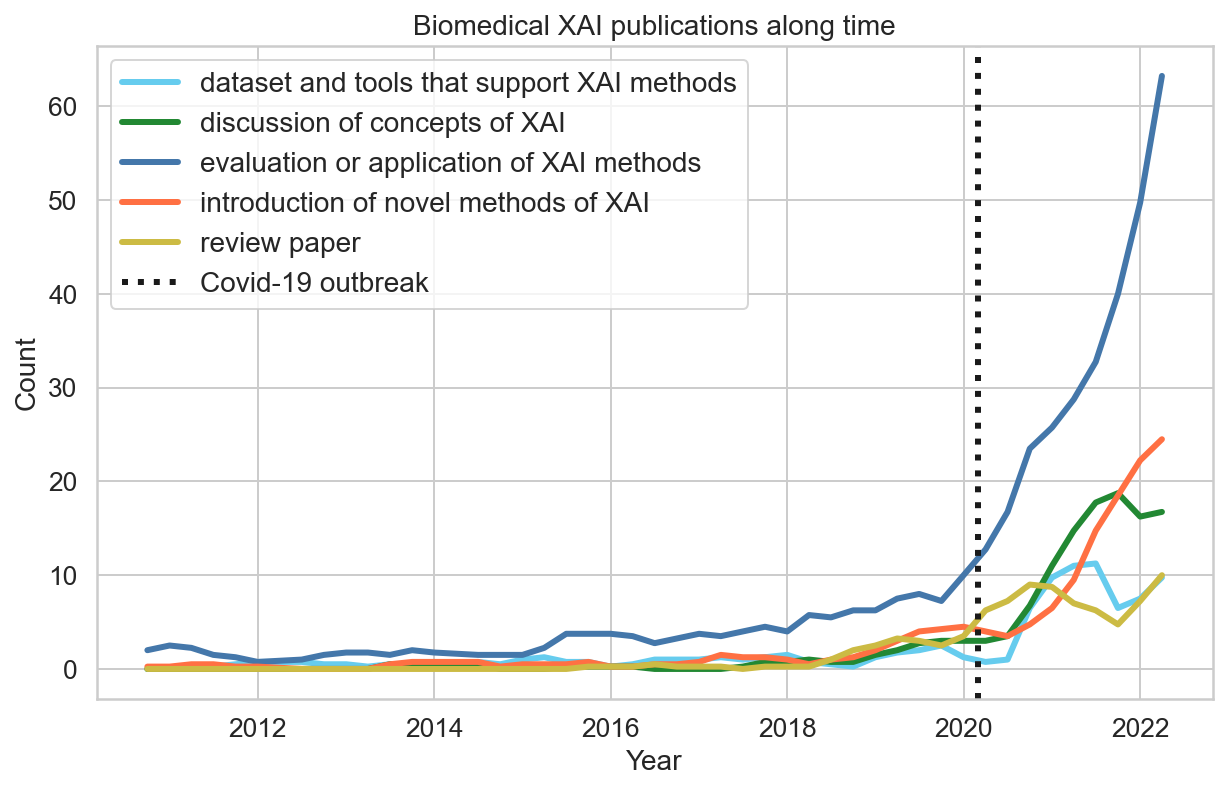

In [17]:

plt.plot(df_quarter_xai_categories['Date'][:-2], 
         df_quarter_xai_categories['dataset and tools that support XAI methods'][:-2], c = '#66CCEE',lw = 3,
        label = 'dataset and tools that support XAI methods')

plt.plot(df_quarter_xai_categories['Date'][:-2], 
         df_quarter_xai_categories['discussion of concepts of XAI'][:-2], c = '#228833', lw = 3,
        label = 'discussion of concepts of XAI')

plt.plot(df_quarter_xai_categories['Date'][:-2], 
         df_quarter_xai_categories['evaluation or application of XAI methods'][:-2], c = '#4477AA',lw = 3,
        label = 'evaluation or application of XAI methods')

plt.plot(df_quarter_xai_categories['Date'][:-2], 
         df_quarter_xai_categories['introduction of novel methods of XAI'][:-2], c = '#FF7043',lw = 3,
        label = 'introduction of novel methods of XAI')

plt.plot(df_quarter_xai_categories['Date'][:-2], 
         df_quarter_xai_categories['review paper'][:-2], c = '#CCBB44', lw = 3,label = 'review paper')

plt.axvline( pd.Timestamp(2020, 3, 1), label = 'Covid-19 outbreak', lw = 3, c = 'k', ls = 'dotted')

plt.xlabel ('Year', fontsize = 14)
plt.ylabel ('Count', fontsize = 14)
plt.legend(fontsize = 14)
plt.title('Biomedical XAI publications along time', fontsize = 14)

plt.show()


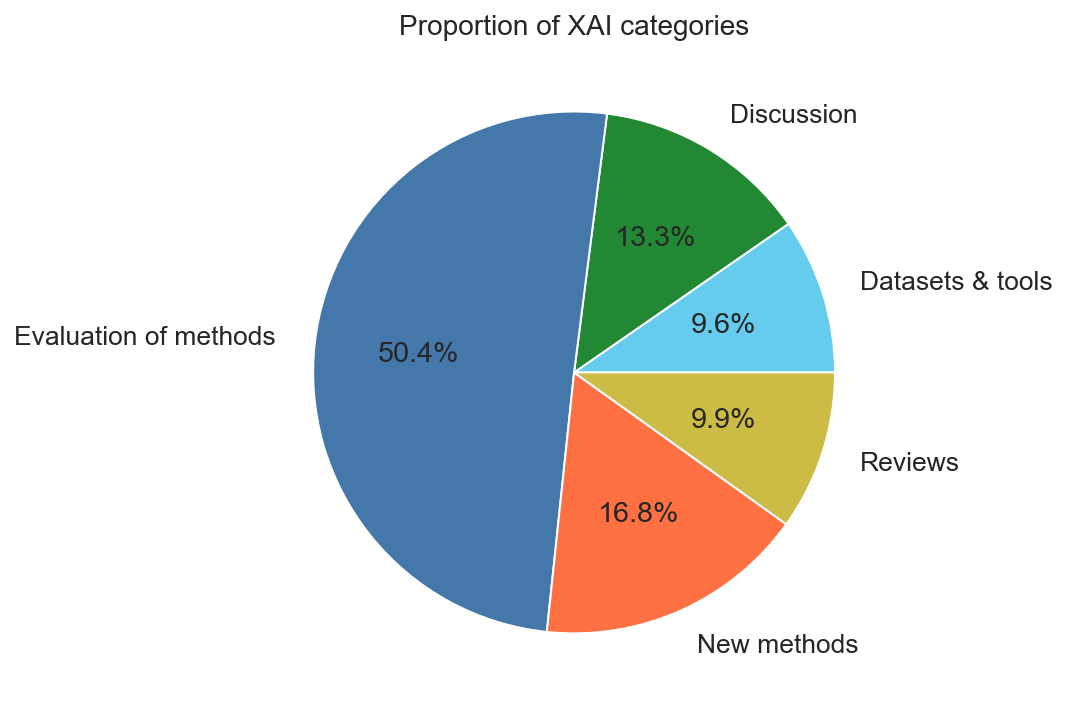

In [18]:

names='Datasets & tools', 'Discussion', 'Evaluation of methods', 'New methods', 'Reviews'
values=[df[df['Relation to XAI'] == 'dataset and tools that support XAI methods'].shape[0]/df.shape[0]*100,
        df[df['Relation to XAI'] == 'discussion of concepts of XAI'].shape[0]/df.shape[0]*100,
        df[df['Relation to XAI'] == 'evaluation or application of XAI methods'].shape[0]/df.shape[0]*100,
        df[df['Relation to XAI'] == 'introduction of novel methods of XAI'].shape[0]/df.shape[0]*100,
        df[df['Relation to XAI'] == 'review paper'].shape[0]/df.shape[0]*100]
       

colors = [ '#66CCEE','#228833','#4477AA',  '#FF7043', '#CCBB44']
 
    
# Create a pieplot


# Label distance: gives the space between labels and the center of the pie
plt.pie(values, labels=names, labeldistance=1.15, autopct='%1.1f%%', 
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors);
plt.title('Proportion of XAI categories', fontsize = 14)
plt.savefig('figures/xai_piechart.pdf')
plt.show();

In [19]:
df['Role of Covid-19'].value_counts()

Covid is not mentioned in the title or abstract                    1137
Covid data/use case is the topic of the study                       101
Covid is mentioned as a reason/driving force for explainability      37
Name: Role of Covid-19, dtype: int64

#### Covid-19

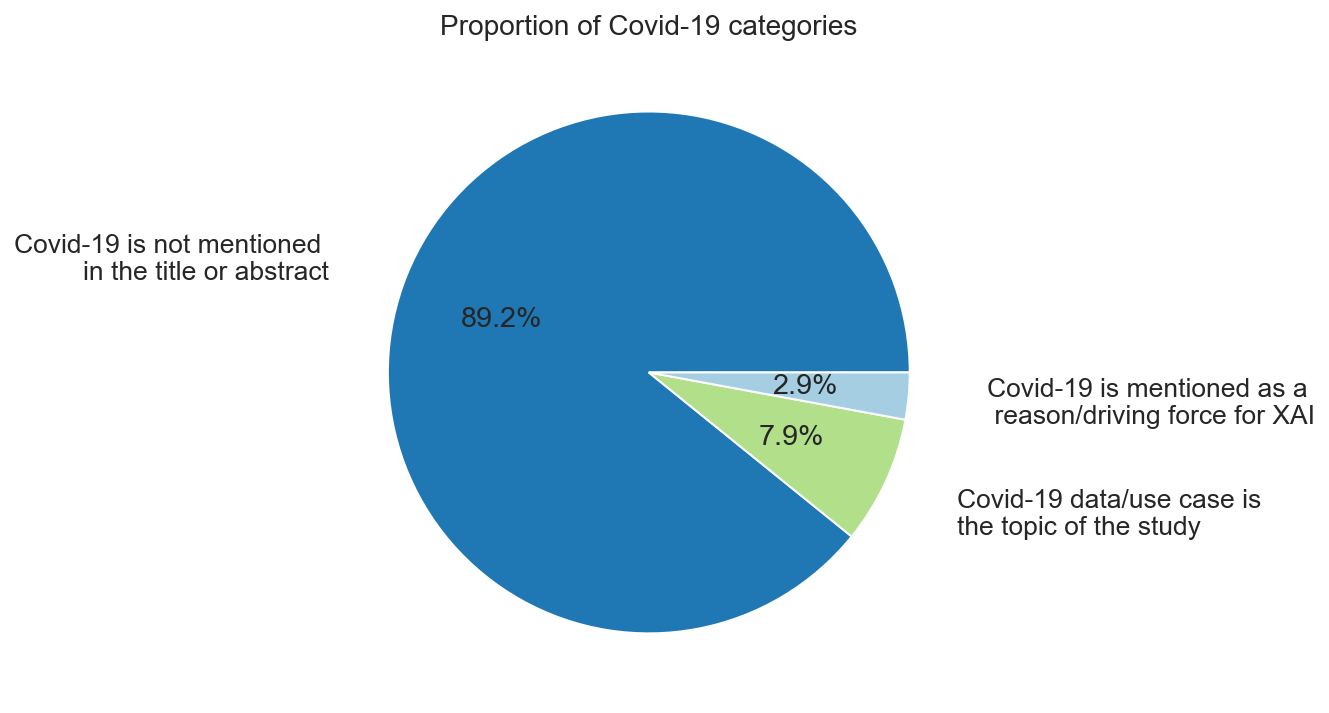

In [20]:

names= 'Covid-19 is not mentioned \nin the title or abstract', 'Covid-19 data/use case is \nthe topic of the study',\
'Covid-19 is mentioned as a\n reason/driving force for XAI'

values=[df[df['Role of Covid-19'] == 'Covid is not mentioned in the title or abstract'].shape[0]/df.shape[0]*100,
        df[df['Role of Covid-19'] == 'Covid data/use case is the topic of the study'].shape[0]/df.shape[0]*100,
        df[df['Role of Covid-19'] == 'Covid is mentioned as a reason/driving force for explainability'].shape[0]/df.shape[0]*100]
       

colors = [ '#1f78b4','#b2df8a', '#a6cee3']
 
    
# Create a pieplot


# Label distance: gives the space between labels and the center of the pie
plt.pie(values, labels=names, labeldistance=1.3, autopct='%1.1f%%', 
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors);
plt.title('Proportion of Covid-19 categories', fontsize = 14)
plt.show()

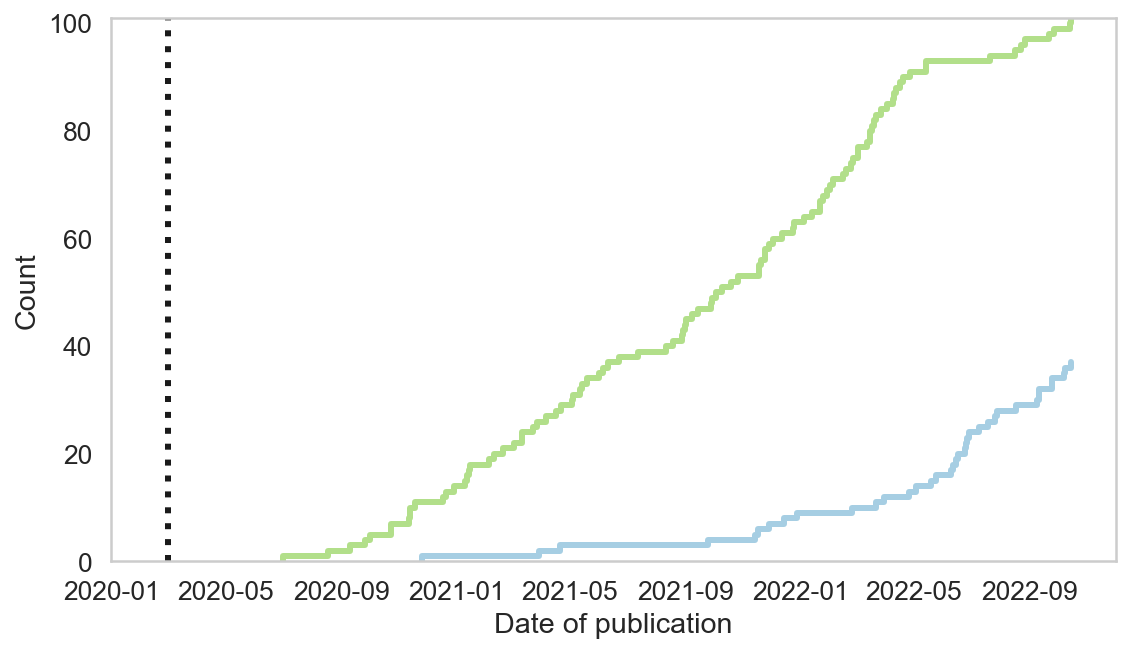

In [21]:
fig, ax1 = plt.subplots(figsize = (9, 5))

df2 = df[df['Role of Covid-19'] != 'Covid is not mentioned in the title or abstract']
sns.ecdfplot(data=df2, x="Date of publication", hue="Role of Covid-19", 
             stat="count", 
             legend=False,
             palette= ['#b2df8a', '#a6cee3'],
#              palette =  ['#1f78b4','#b2df8a', '#a6cee3'],
             lw=3)

plt.axvline(dt.datetime(2020, 3, 1), label = 'Covid-19 outbreak', lw = 3, c = 'k', ls = 'dotted')
plt.xlim(dt.datetime(2020, 1, 1), dt.datetime(2022, 12, 1))

plt.grid(False)


plt.show()

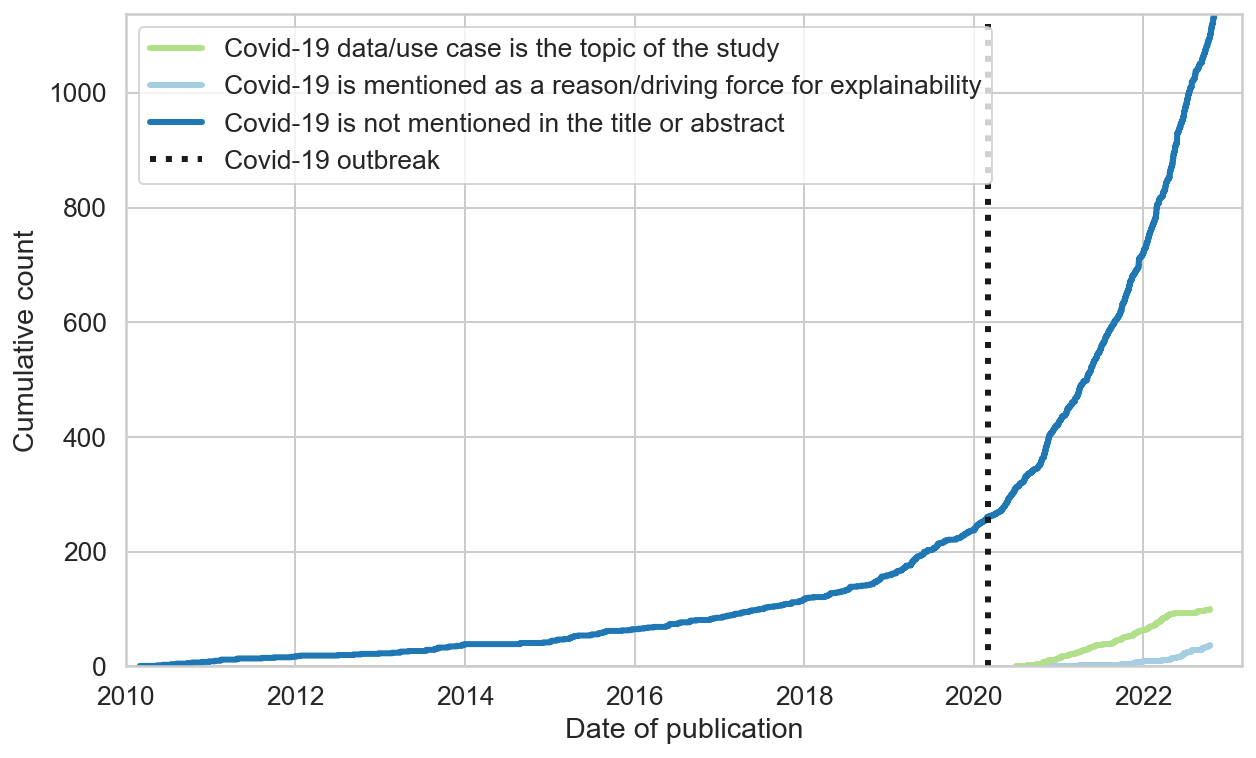

In [22]:

sns.ecdfplot(data=df, x="Date of publication", hue="Role of Covid-19", 
             stat="count", 
             legend=True,
#              palette= ['#b2df8a', '#a6cee3'],
             palette =  ['#1f78b4','#b2df8a', '#a6cee3'],
             lw=3)

plt.axvline(dt.datetime(1990, 3, 1), label = 'Covid-19 data/use case is the topic of the study', lw = 3, c = '#b2df8a')
plt.axvline(dt.datetime(1990, 3, 1), label = 'Covid-19 is mentioned as a reason/driving force for explainability', lw = 3,
            c = '#a6cee3')
plt.axvline(dt.datetime(1990, 3, 1), label = 'Covid-19 is not mentioned in the title or abstract', lw = 3,
            c = '#1f78b4')
plt.axvline(dt.datetime(2020, 3, 1), label = 'Covid-19 outbreak', lw = 3, c = 'k', ls = 'dotted')
plt.xlim(dt.datetime(2010, 1, 1), dt.datetime(2023, 3, 1))



plt.ylabel('Cumulative count')
plt.legend()

plt.show()